In [1]:
from windrose import WindroseAxes, plot_windrose
import calendar
import folium
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mitosheet
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import warnings
from prettytable import PrettyTable

warnings.filterwarnings("ignore")


plt.rcParams.update(
    {
        "axes.titlesize": 20,  # Title font size
        "axes.labelpad": 10,  # Padding for the x and y labels
        "axes.labelcolor": "dimgray",
        "xtick.labelsize": 16,  # Font size for the x tick labels
        "ytick.labelsize": 16,  # Font size for the y tick labels
        "axes.labelsize": 18,  # Font size for the x and y axis labels
        "font.family": "serif",  # Set the font family to Arial
        "grid.linestyle": "--",  # Set the style of the gridlines
        "grid.linewidth": 0.5,  # Set the width of the gridlines
        "grid.color": "gray",  # Set the color of the gridlines
        "axes.grid": True,  # Enable the grid
        "axes.grid.which": "both",  # Apply the grid to both major and minor ticks
        "xtick.direction": "in",  # Set the direction of the x tick marks
        "ytick.direction": "in",  # Set the direction of the y tick marks
        "xtick.major.size": 6,  # Set the length of the major x tick marks
        "xtick.major.width": 2,  # Set the width of the major x tick marks
        "ytick.major.size": 6,  # Set the length of the major y tick marks
        "ytick.major.width": 2,  # Set the width of the major y tick marks
        "xtick.color": "gray",  # Color of x tick labels and tick lines
        "ytick.color": "gray",  # Color of y tick labels and tick lines
    }
)


In [2]:
def read_water_gage_station(filename):
    df = pd.read_csv(
        filename,
        index_col="t",
        usecols=lambda column: column not in ["s", "f_x", "g", "f_y", "direction"],
    )
    return df


WaterGageStation8771972 = read_water_gage_station("WaterGageStation8771972.csv")
# WaterGageStation8772440 = read_water_gage_station("WaterGageStation8772440.csv")
# WaterGageStation8772447 = read_water_gage_station("WaterGageStation8772447.csv")
# WaterGageStation8772471 = read_water_gage_station("WaterGageStation8772471.csv")
# WaterGageStation8773767 = read_water_gage_station("WaterGageStation8773767.csv")


In [3]:
datasets = {
    "Station 8771972": WaterGageStation8771972,
    # "Station 8772440": WaterGageStation8772440,
    # "Station 8772447": WaterGageStation8772447,
    # "Station 8772471": WaterGageStation8772471,
    # "Station 8773767": WaterGageStation8773767,
}


In [4]:
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

rename_columns = {
    "wind_speed": "Wind Speed (m/s)",
    "wind_direction": "Wind Direction (degrees)",
}


In [5]:
def calculate_sand_flux(wind_speed, threshold):
    Q = 32  # m^2/yr
    if pd.isna(wind_speed):
        return np.nan
    elif wind_speed <= threshold:
        return 0
    else:
        return Q * ((wind_speed / threshold) ** 2 - 1)


In [6]:
def adjust_wind_direction(df, direction_column="Wind Direction (degrees)"):
    orientation = 90 - 34
    df["Wind Direction Approaching Island From"] = (
        df[direction_column] - orientation
    ) % 360
    return df


In [7]:
base_path = "windrose_plots"

for dataset_name, df in datasets.items():
    if "water_level" in df.columns:
        df = df.drop("water_level", axis=1)

    df.rename(columns=rename_columns, inplace=True)
    for col in rename_columns.values():
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df.index = pd.to_datetime(df.index)

    # Only insert "Year", "Month", "Day", and "Hour" if they don't already exist
    if "Year" not in df.columns:
        df.insert(0, "Year", df.index.year)
    if "Month" not in df.columns:
        df.insert(1, "Month", df.index.month)
    if "Day" not in df.columns:
        df.insert(2, "Day", df.index.day)
    if "Hour" not in df.columns:
        df.insert(3, "Hour", df.index.hour)

    df = df[df["Year"] != 2024]
    df = df.dropna(subset=["Wind Speed (m/s)", "Wind Direction (degrees)"])
    df = adjust_wind_direction(df, direction_column="Wind Direction (degrees)")

    df["Flux_Threshold_4"] = df["Wind Speed (m/s)"].apply(
        calculate_sand_flux, args=(4,)
    )
    df["Flux_Threshold_5"] = df["Wind Speed (m/s)"].apply(
        calculate_sand_flux, args=(5,)
    )

    df.loc[
        ((df["Hour"] > 18) | (df["Hour"] < 6)), ["Flux_Threshold_4", "Flux_Threshold_5"]
    ] = 0

    df["Sin_Direction_Flux_4"] = (
        np.sin(np.radians(df["Wind Direction Approaching Island From"]))
        * df["Flux_Threshold_4"]
    )
    df["Sin_Direction_Flux_5"] = (
        np.sin(np.radians(df["Wind Direction Approaching Island From"]))
        * df["Flux_Threshold_5"]
    )

    df["Cos_Direction_Flux_4"] = (
        np.cos(np.radians(df["Wind Direction Approaching Island From"]))
        * df["Flux_Threshold_4"]
    )
    df["Cos_Direction_Flux_5"] = (
        np.cos(np.radians(df["Wind Direction Approaching Island From"]))
        * df["Flux_Threshold_5"]
    )

    datasets[dataset_name] = df
    df.to_csv(os.path.join(base_path, f"{dataset_name}.csv"))


In [8]:

print(ratio)


0.23


In [9]:
for dataset_name, df in datasets.items():

    avg_total_flux_wind_speed_threshold_4 = round(df["Flux_Threshold_4"].mean(), 2)
    avg_total_flux_wind_speed_threshold_5 = round(df["Flux_Threshold_5"].mean(), 2)

    df_filtered = df[
        (df["Wind Direction Approaching Island From"] >= 0)
        & (df["Wind Direction Approaching Island From"] <= 180)
    ]
    avg_total_flux_sin_direction_wind_speed_threshold_4 = round(
        df_filtered["Sin_Direction_Flux_4"].mean(), 2
    )
    avg_total_flux_sin_direction_wind_speed_threshold_5 = round(
        df_filtered["Sin_Direction_Flux_5"].mean(), 2
    )

    avg_flux_U_greater_than_Ut_wind_speed_threshold_4 = round(
        df[df["Flux_Threshold_4"] > 0]["Flux_Threshold_4"].mean(), 2
    )
    avg_flux_U_greater_than_Ut_wind_speed_threshold_5 = round(
        df[df["Flux_Threshold_5"] > 0]["Flux_Threshold_5"].mean(), 2
    )

    average_flux_sind_direction_U_greater_than_Ut_wind_speed_threshold_4 = round(
        df_filtered[df_filtered["Flux_Threshold_4"] > 0]["Sin_Direction_Flux_4"].mean(),
        2,
    )
    average_flux_sind_direction_U_greater_than_Ut_wind_speed_threshold_5 = round(
        df_filtered[df_filtered["Flux_Threshold_5"] > 0]["Sin_Direction_Flux_5"].mean(),
        2,
    )


In [10]:
from prettytable import PrettyTable

# Initialize PrettyTable with column names
table = PrettyTable(["Variable", "Value"])

# Add rows for each variable vertically
table.add_row(
    ["Average Total Flux (Threshold 4)", avg_total_flux_wind_speed_threshold_4]
)
table.add_row(
    ["Average Total Flux (Threshold 5)", avg_total_flux_wind_speed_threshold_5]
)
table.add_row(
    [
        "Average Total Flux Sin Direction (Threshold 4)",
        avg_total_flux_sin_direction_wind_speed_threshold_4,
    ]
)
table.add_row(
    [
        "Average Total Flux Sin Direction (Threshold 5)",
        avg_total_flux_sin_direction_wind_speed_threshold_5,
    ]
)
table.add_row(
    [
        "Average Flux (U > Ut) (Threshold 4)",
        avg_flux_U_greater_than_Ut_wind_speed_threshold_4,
    ]
)
table.add_row(
    [
        "Average Flux (U > Ut) (Threshold 5)",
        avg_flux_U_greater_than_Ut_wind_speed_threshold_5,
    ]
)
table.add_row(
    [
        "Average Flux Sin Direction (U > Ut) (Threshold 4)",
        average_flux_sind_direction_U_greater_than_Ut_wind_speed_threshold_4,
    ]
)
table.add_row(
    [
        "Average Flux Sin Direction (U > Ut) (Threshold 5)",
        average_flux_sind_direction_U_greater_than_Ut_wind_speed_threshold_5,
    ]
)

# Print the table
print(table)


+---------------------------------------------------+-------+
|                      Variable                     | Value |
+---------------------------------------------------+-------+
|          Average Total Flux (Threshold 4)         | 18.42 |
|          Average Total Flux (Threshold 5)         |  8.44 |
|   Average Total Flux Sin Direction (Threshold 4)  |  6.87 |
|   Average Total Flux Sin Direction (Threshold 5)  |  2.32 |
|        Average Flux (U > Ut) (Threshold 4)        | 53.43 |
|        Average Flux (U > Ut) (Threshold 5)        | 36.56 |
| Average Flux Sin Direction (U > Ut) (Threshold 4) | 21.41 |
| Average Flux Sin Direction (U > Ut) (Threshold 5) | 12.48 |
+---------------------------------------------------+-------+


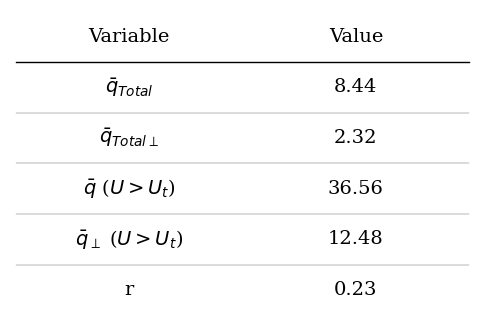

In [11]:
from plottable import Table, ColumnDefinition, ColDef


# Assuming previous calculations for avg_total_flux_wind_speed_threshold_5 and other variables
# Create a DataFrame to hold the variables and their values
import pandas as pd

data = {
    "Variable": [
        "$\\bar{q}_{Total}$",
        "$\\bar{q}_{{Total}{\\perp}}$",
        "$\\bar{q}$ ($U > U_t$)",
        "$\\bar{q}_{\\perp}$ ($U > U_t$)",
        "r",
    ],
    "Value": [
        avg_total_flux_wind_speed_threshold_5,
        avg_total_flux_sin_direction_wind_speed_threshold_5,
        avg_flux_U_greater_than_Ut_wind_speed_threshold_5,
        average_flux_sind_direction_U_greater_than_Ut_wind_speed_threshold_5,
        ratio,
    ],
}

df_table = pd.DataFrame(data).set_index("Variable")
# Create the plot and table
fig, ax = plt.subplots(figsize=(6, 4))  # Adjusted for better fit of the table
ax.axis("tight")
ax.axis("off")
tab = Table(
    df_table,
    cell_kw={
        "linewidth": 0,
        "edgecolor": "k",
    },
    textprops={"fontsize": 14, "ha": "center"},
)
plt.show()


In [12]:
print(np.nansum(df["Flux_Threshold_5"].values ** 2))
print(
    np.nansum(df["Sin_Direction_Flux_5"].values ** 2)
    + np.nansum(df["Cos_Direction_Flux_5"].values ** 2)
)


41090578.86470145
41090578.86470144


In [24]:
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)

def plot_windrose_facetgrid(
    df,
    direction_column="wind_direction",
    magnitude_column="wind_speed",
    base_path=None,
    subfolder=None,
    title=None,
):

    if base_path and subfolder:
        full_path = os.path.join(base_path, subfolder)
        os.makedirs(full_path, exist_ok=True)
    else:
        full_path = base_path

    g = sns.FacetGrid(
        data=df,
        col="Year",
        col_wrap=3,
        subplot_kws={"projection": "windrose"},
        sharex=False,
        sharey=False,
        despine=False,
        height=3.5,
    )

    if magnitude_column == "Wind Speed (m/s)":
        bins = (0, 2, 3, 4, 5)
    elif magnitude_column in ["Flux_Threshold_4", "Flux_Threshold_5"]:
        bins = (0.01, 15, 30, 70, 100)
        pass

    g.map_dataframe(
        plot_windrose_subplots,
        direction=direction_column,
        var=magnitude_column,
        normed=True,
        bins=bins,
        # calm_limit=0.1,
        kind="bar",
        clean_flag = True,
    )

    y_ticks = range(0, 17, 4)
    if magnitude_column == "Wind Speed (m/s)":
        legend_title = "$m \cdot s^{-1}$"
    elif magnitude_column in ["Flux_Threshold_4", "Flux_Threshold_5"]:
        legend_title = "$m^2 \cdot yr^{-1}$"
    for ax in g.axes:
        ax.set_legend(
            title=legend_title, bbox_to_anchor=(1.15, -0.1), loc="lower right"
        )
        ax.set_rgrids(y_ticks, y_ticks)
    plt.subplots_adjust(wspace=-0.2, top=0.9)
    if title:
        plt.suptitle(title, fontsize=16)

    if full_path:
        title = title.replace("/", "_")
        save_path = os.path.join(full_path, f"{title}_windrose.png")
        print(save_path)
        
        plt.savefig(save_path, format="png", dpi=300)
        plt.show()


In [25]:
column_pairs = [
    ("Wind Direction (degrees)", "Wind Speed (m/s)"),
    # ("Wind Direction (degrees)", "Flux_Threshold_4"),
    ("Wind Direction (degrees)", "Flux_Threshold_5"),
]


windrose_plots/Station 8771972/Wind speed (m_s) vs. Wind direction (degrees) for Station 8771972_windrose.png


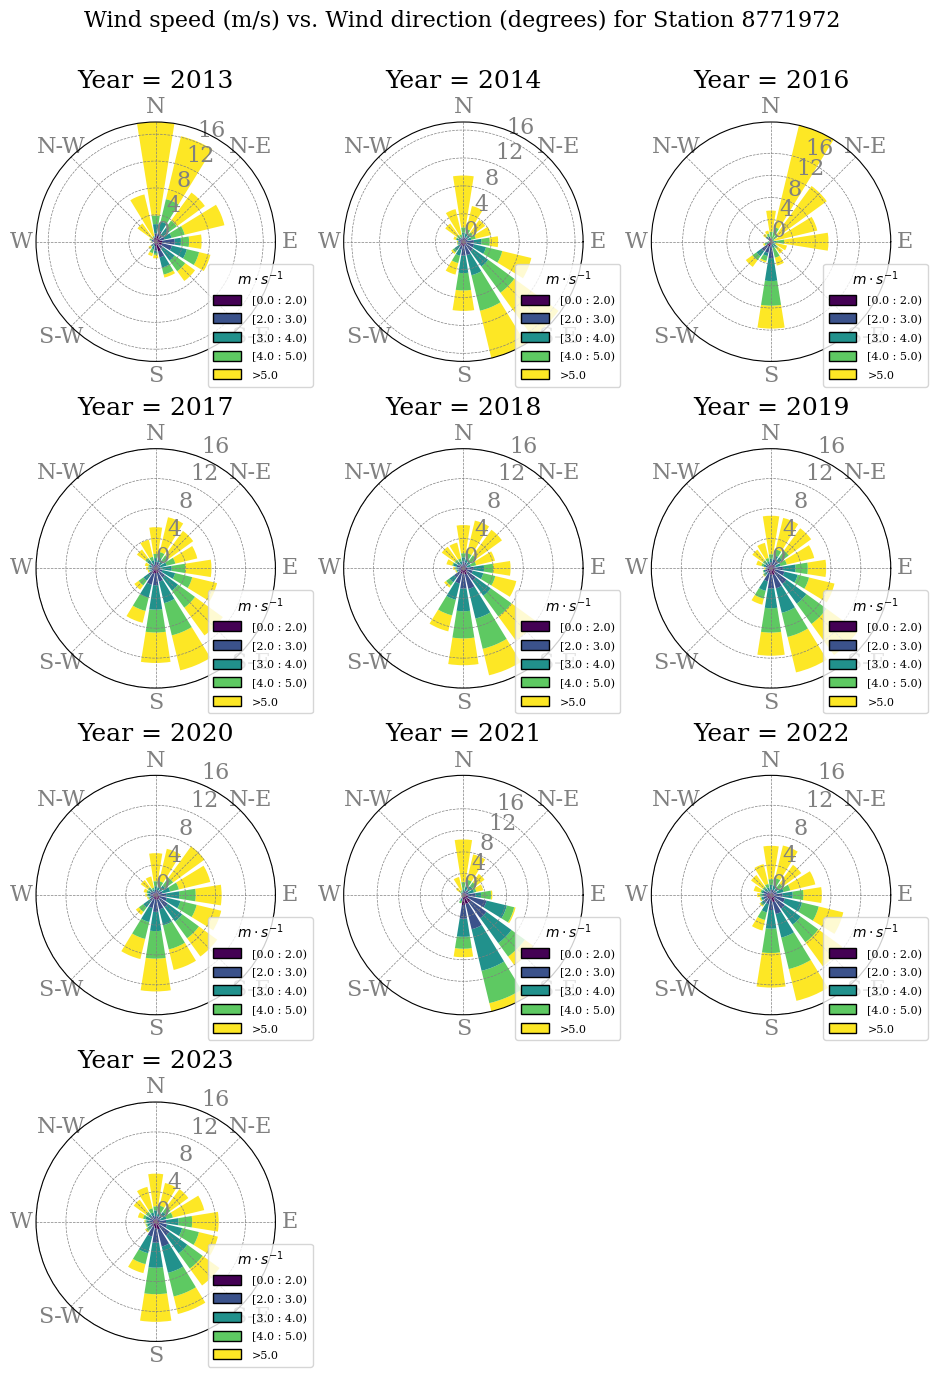

windrose_plots/Station 8771972/Flux_threshold_5 vs. Wind direction (degrees) for Station 8771972_windrose.png


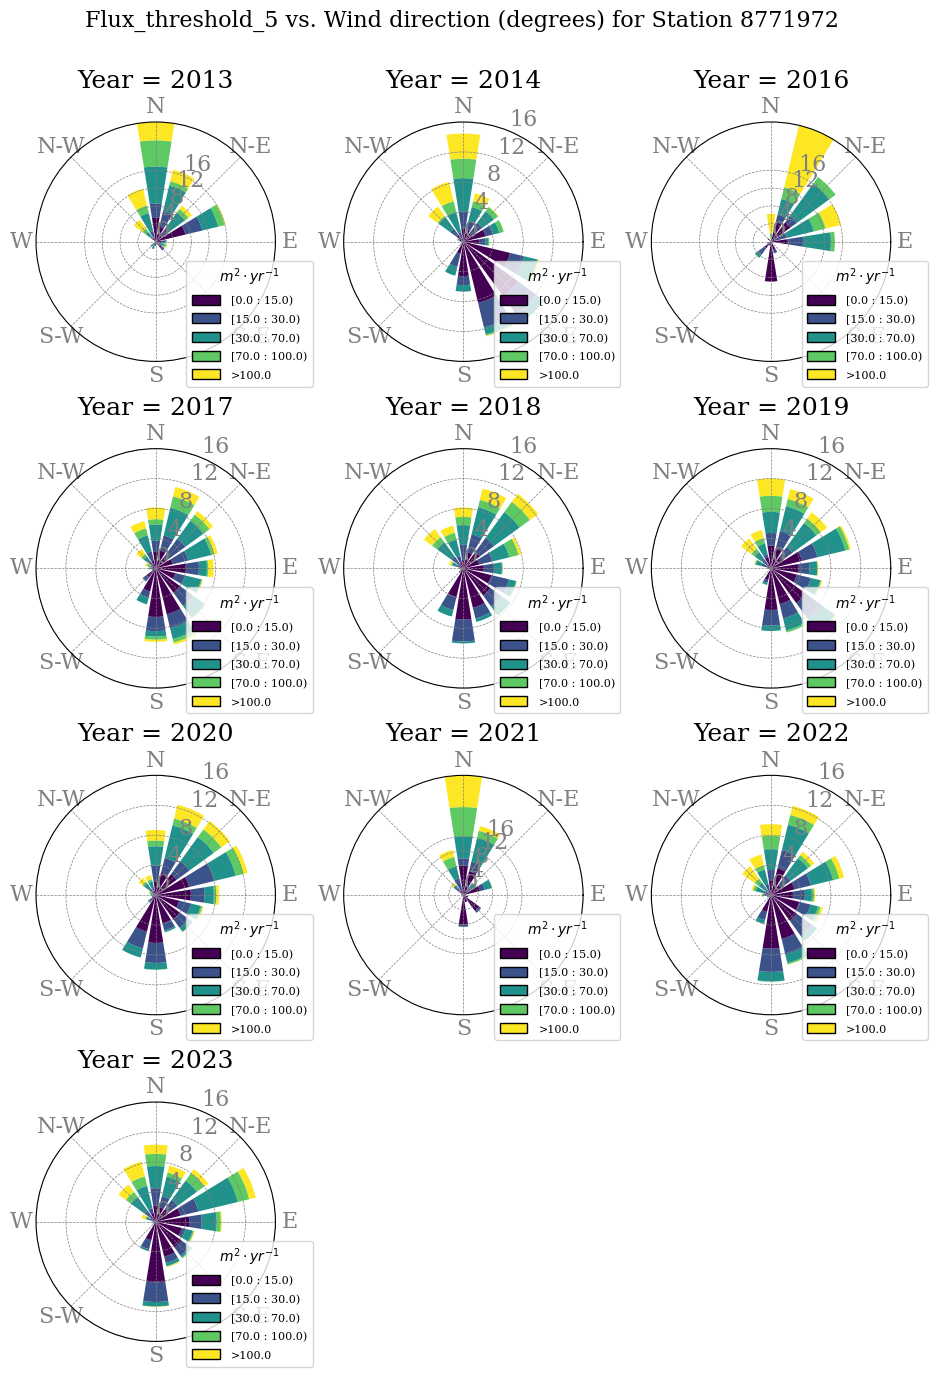

error uploading: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)')))


In [26]:
for dataset_name, df in datasets.items():
    for direction_column, magnitude_column in column_pairs:
        title = f"{magnitude_column.capitalize()} vs. {direction_column.capitalize()} for {dataset_name}"

        plot_windrose_facetgrid(
            df,
            direction_column=direction_column,
            magnitude_column=magnitude_column,
            title=title,
            base_path=base_path,
            subfolder=dataset_name,
        )


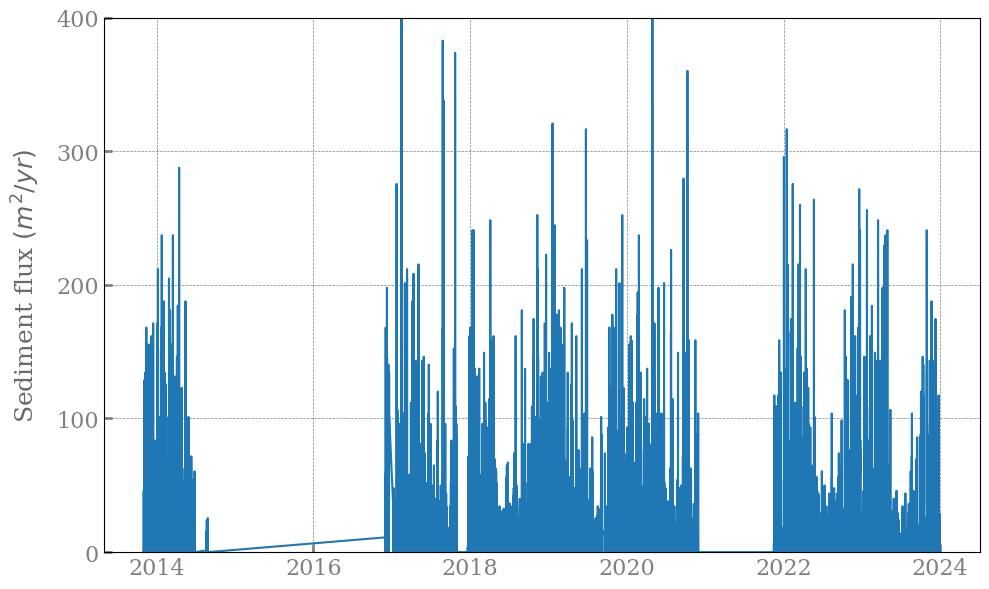

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y=df["Flux_Threshold_5"])
plt.ylabel("Sediment flux $(m^2/yr)$")
plt.xlabel("")
plt.xticks(rotation=0)
# plt.xlim(pd.to_datetime("2014-01-01"), pd.to_datetime("2023-12-31"))
plt.ylim(0, 400)
plt.yticks([0, 100, 200, 300, 400])
# plt.xticks(pd.date_range(start="2014-01-01", end="2023-12-31", freq='YS'))

plt.tight_layout()
plt.savefig("sediment_flux_plot.png")
plt.show()


In [18]:
month_map = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

month_order = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]


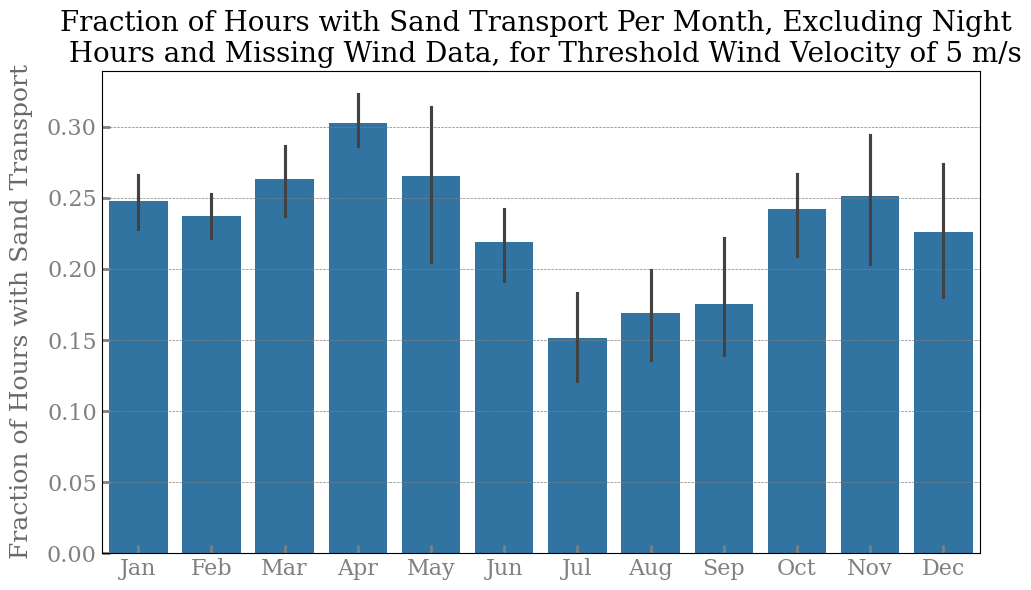

In [19]:
df_filtered = df.dropna(subset=["Flux_Threshold_5"])
total_hours_per_month = df_filtered.resample("M").size()

sand_transport_hours = (
    df_filtered[df_filtered["Flux_Threshold_5"] > 0].resample("M").size()
)

fractions = sand_transport_hours / total_hours_per_month

fractions_df = fractions.reset_index(name="Fraction")
fractions_df["Month"] = fractions_df["t"].dt.strftime("%m").astype(float)
fractions_df["Year"] = fractions_df["t"].dt.strftime("%Y").astype(float)


fractions_df["Month"] = fractions_df["Month"].map(month_map)
fractions_df["Month"] = pd.Categorical(
    fractions_df["Month"], categories=month_order, ordered=True
)

plt.figure(figsize=(10, 6))
sns.barplot(x="Month", y="Fraction", data=fractions_df)
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Fraction of Hours with Sand Transport")
plt.title(
    "Fraction of Hours with Sand Transport Per Month, Excluding Night \n Hours and Missing Wind Data, for Threshold Wind Velocity of 5 m/s"
)
plt.tight_layout()
plt.savefig(
    "sand_transport_fraction_excluding_night_and_no_wind_for_5ms_threshold.png", dpi=300
)
plt.show()


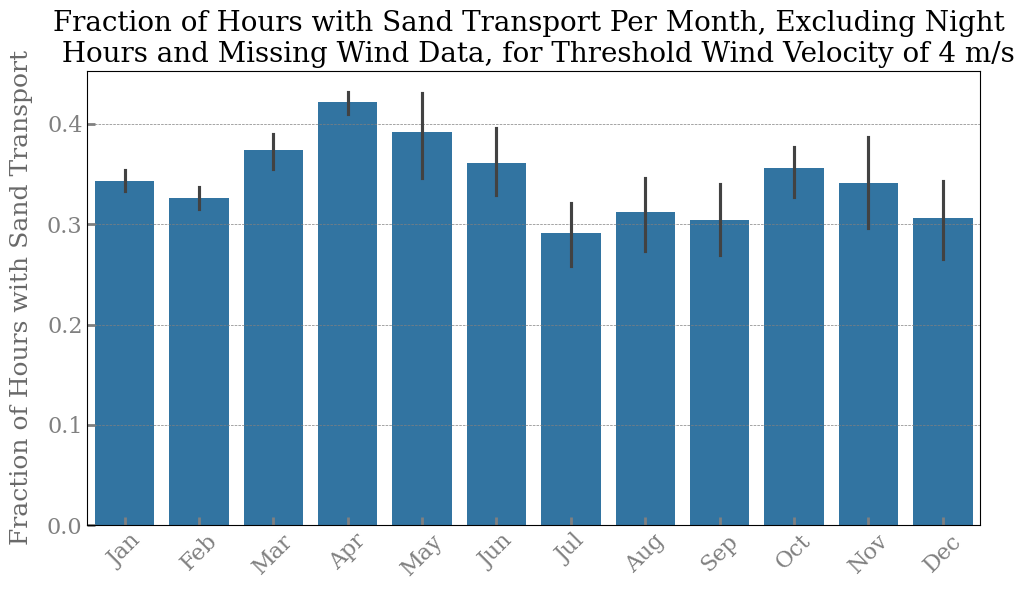

In [20]:
df_filtered = df.dropna(subset=["Flux_Threshold_4"])
total_hours_per_month = df_filtered.resample("M").size()

sand_transport_hours = (
    df_filtered[df_filtered["Flux_Threshold_4"] != 0].resample("M").size()
)

fractions = sand_transport_hours / total_hours_per_month

fractions_df = fractions.reset_index(name="Fraction")
fractions_df["Month"] = fractions_df["t"].dt.strftime("%m").astype(float)
fractions_df["Year"] = fractions_df["t"].dt.strftime("%Y").astype(float)


fractions_df["Month"] = fractions_df["Month"].map(month_map)
fractions_df["Month"] = pd.Categorical(
    fractions_df["Month"], categories=month_order, ordered=True
)

plt.figure(figsize=(10, 6))
sns.barplot(x="Month", y="Fraction", data=fractions_df)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Fraction of Hours with Sand Transport")
plt.title(
    "Fraction of Hours with Sand Transport Per Month, Excluding Night \n Hours and Missing Wind Data, for Threshold Wind Velocity of 4 m/s"
)
plt.tight_layout()
plt.savefig(
    "sand_transport_fraction_excluding_night_and_no_wind_for_4ms_threshold.png", dpi=300
)
plt.show()


In [21]:
df_filtered = df.dropna(subset=["Wind Speed (m/s)"])
df_filtered = df_filtered[["Wind Speed (m/s)"]]
df_filtered["U_Ut"] = df_filtered["Wind Speed (m/s)"] / 5
df_filtered[df["Wind Speed (m/s)"] > 5]["U_Ut"].mean()


1.4225310440668848